In [72]:
import os

import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import seaborn as sns

from reaches import *

## Setup

In [4]:
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'

In [5]:
# Get NHD index metadata
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
huc_lookup = pd.read_csv(os.path.join(mdata_path,
                                  'HUC4_lookup_no_great_lakes.csv'),
                     dtype=dtype_dic)

In [69]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [73]:
cmap = plt.get_cmap('cubehelix', 5)
new_cmap = truncate_colormap(cmap, 0.2, 0.75)

In [74]:
color = []

for i in np.linspace(0, 1, 3):
    color.append(colors.rgb2hex(new_cmap(i)))

In [75]:
# palette = sns.color_palette(color)
palette_two = sns.color_palette(color[:-1])

In [110]:
# Order of all possible bins for plotting
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
         '(100, 150]', '(150, 200]', '(200, 500]']

## Get HUCs

In [6]:
# Read in HUC4 boundaries (no Great Lakes)
data_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/all_wbd_no_great_lakes.parquet'
wbd = gpd.read_parquet(path=data_path)

In [7]:
# Project CRS
wbd = wbd.to_crs(epsg=3857)

In [8]:
hucs_01 = wbd[wbd['huc4'].str.startswith('01')]['huc4'].to_list()

In [9]:
hucs_15 = wbd[wbd['huc4'].str.startswith('15')]['huc4'].to_list()

In [10]:
# Extract indices for read-in
indices_01 = list(huc_lookup[huc_lookup['HUC4'].isin(hucs_01)]['slurm_index'])
indices_15 = list(huc_lookup[huc_lookup['HUC4'].isin(hucs_15)]['slurm_index'])

## Analysis

In [ ]:
# Create merged dataframe of all flowlines intersected
# Initialize lists
d = []

# Loop through indices and store in lists
for i in indices_01:
    # Read prepped NHD
    flowlines, _, _ = readNHD(index=i)
    # Append to lists
    d.append(flowlines)
# Merge GeoDataFrames
flowlines_01 = pd.concat(d)

In [ ]:
# Create merged dataframe of all flowlines intersected
# Initialize lists
d = []

# Loop through indices and store in lists
for i in indices_15:
    # Read prepped NHD
    flowlines, _, _ = readNHD(index=i)
    # Append to lists
    d.append(flowlines)
# Merge GeoDataFrames
flowlines_15 = pd.concat(d)

In [56]:
flowlines_01['huc2'] = '01'
flowlines_15['huc2'] = '15'

In [57]:
flowlines_15.shape[0]

623321

In [95]:
temp_01 = flowlines_01[['StreamOrde', 'Bin', 'huc2']]
temp_15 = flowlines_15[['StreamOrde', 'Bin', 'huc2']]

In [96]:
both = pd.concat(objs=[temp_01, temp_15]).reset_index().drop(columns='index')

In [107]:
both['Bin'] = pd.Categorical(both['Bin'], order)

In [ ]:
both

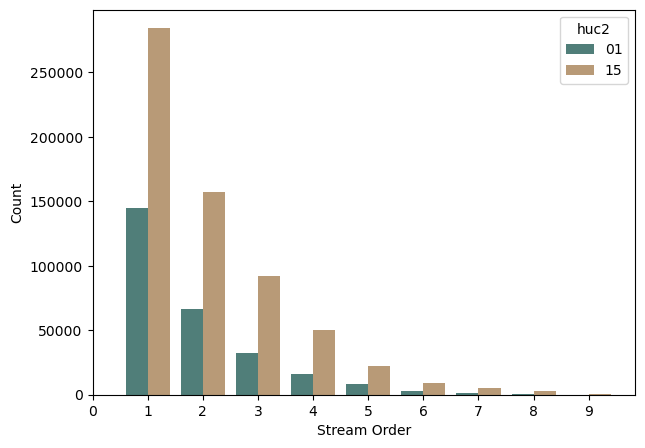

In [94]:
fig, ax = plt.subplots(figsize=(7,5))

sns.histplot(data=both, x="StreamOrde",
             hue="huc2", palette=palette_two,
             multiple="dodge", discrete=True,
             shrink=0.8, edgecolor='None',
             legend=True, ax=ax)

plt.xlabel('Stream Order');
plt.xticks(np.arange(0,10));

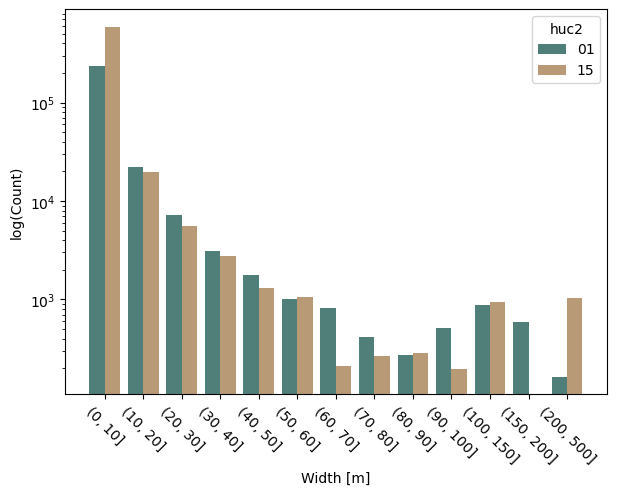

In [120]:
fig, ax = plt.subplots(figsize=(7,5))

sns.histplot(data=both, x="Bin", log_scale=True,
             hue="huc2", palette=palette_two,
             multiple="dodge", discrete=True,
             shrink=0.8, edgecolor='None',
             legend=True)

plt.xlabel('Width [m]');
plt.ylabel('log(Count)')
plt.yscale('log')
plt.xticks(rotation=-45)
plt.xticks(np.arange(0,13));